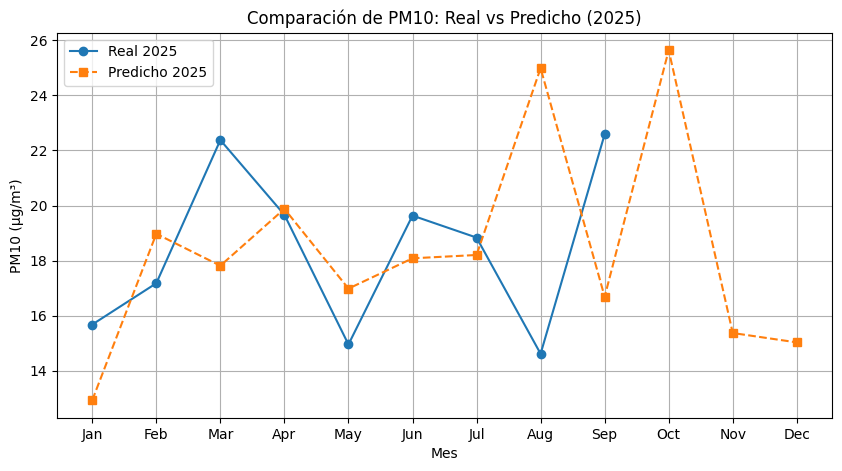

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ===================
# 1. Leer datasets
# ===================
df_2023 = pd.read_csv("PM10_2023.csv")
df_2024 = pd.read_csv("PM10_2024.csv")
df_2025 = pd.read_csv("PM10_2025.csv")

# Agregar columna año
df_2023["Year"] = 2023
df_2024["Year"] = 2024
df_2025["Year"] = 2025

# Unir datasets
df_total = pd.concat([df_2023, df_2024, df_2025], ignore_index=True)

# Procesar fechas
df_total["Date"] = pd.to_datetime(df_total["Date"])
df_total["Month"] = df_total["Date"].dt.month

# Seleccionar columnas necesarias
df_relevant = df_total[["Year", "Month", "Daily Mean PM10 Concentration"]]

# Crear tabla pivote con promedios mensuales
df_pivot = df_relevant.pivot_table(
    index="Year",
    columns="Month",
    values="Daily Mean PM10 Concentration",
    aggfunc="mean"
).reset_index()

# Renombrar columnas de meses
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_pivot.columns = ["Year"] + month_names

# ===================
# 2. Preparar datos ML
# ===================
df_shifted = df_pivot.copy()
df_shifted["Year"] = df_shifted["Year"] - 1  # asociar features con target

df_ml = pd.merge(df_pivot, df_shifted, on="Year", suffixes=("", "_next"))

# Eliminar filas con NaN (último año no tiene target)
df_ml = df_ml.dropna()

X = df_ml[month_names]  # features actuales
y = df_ml[[m + "_next" for m in month_names]]  # target: año siguiente

# Entrenar modelo
model = LinearRegression()
model.fit(X, y)


# Entrenar modelo
model = LinearRegression()
model.fit(X, y)

# ===================
# 3. Predicción para 2025
# ===================
last_year = df_pivot[df_pivot["Year"] == 2024]
X_new = last_year.drop(columns="Year")
y_pred = model.predict(X_new)

pred_df = pd.DataFrame(y_pred, columns=month_names)

# ===================
# 4. Comparar con reales
# ===================
real_2025 = df_pivot[df_pivot["Year"] == 2025][month_names].values.flatten()
pred_2025 = pred_df.values.flatten()

plt.figure(figsize=(10,5))
plt.plot(month_names, real_2025, marker="o", label="Real 2025")
plt.plot(month_names, pred_2025, marker="s", label="Predicho 2025", linestyle="--")
plt.xlabel("Mes")
plt.ylabel("PM10 (µg/m³)")
plt.title("Comparación de PM10: Real vs Predicho (2025)")
plt.legend()
plt.grid(True)
plt.show()
